In [33]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from skimage import io
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Colab specific

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model constants

In [60]:
NUMBER_OF_GRID_ELEMENTS = 100
TEST_PERCENTAGE = 0.1
SAMPLES_TO_SHOW = 5

LONDON_PHOTO_DIR = '/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/train/london'

## Load the data

### Some utilities

In [44]:
from os import listdir
from os.path import isfile, join


def get_file_names_in_dir(dir: str):
    return [f for f in listdir(dir) if isfile(join(dir, f))]


In [43]:
def take_coordinate_from_file_name(file_name: str):
    long, lat = file_name.split('_')

    # Remove .jpg
    lat = lat[:-4]

    return float(long), float(lat)


### Create data set class

In [46]:
class StreetViewImagesDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        self.all_image_names = get_file_names_in_dir(self.root_dir)
        self.all_coordinates = list(map(take_coordinate_from_file_name, self.all_image_names))

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.all_image_names, self.all_coordinates, test_size=TEST_PERCENTAGE, random_state=42)

        self.selected_images_names = self.X_train
        self.selected_coordinates = self.y_train

        if self.train == False:
          self.selected_images_names = self.X_test
          self.selected_coordinates = self.y_test

    def __len__(self):
        return len(self.selected_images_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            # TODO: check out whether this thing really gets called
            print('xxxxx')
            idx = idx.tolist()

        image = io.imread(self.root_dir + '/' + self.selected_images_names[idx])

        if self.transform:
            image = self.transform(image)

        # TODO: make sure the correct grid element is returned here
        return image, self.selected_coordinates[idx]


### Create the data loaders

In [47]:
train_loader = StreetViewImagesDataset(root_dir=LONDON_PHOTO_DIR,
                                           transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              # TODO: add cropping etc.
                                              #  torchvision.transforms.Resize((224, 224))
                                              #  RandomCrop(224),
                                           ]))

# TODO!
# test_loader

# TODO!
data_loader = DataLoader(train_loader, batch_size=4,
                        shuffle=True, num_workers=0)

### Preview some training images

0 torch.Size([3, 640, 640]) (51.5501, -0.057927)
1 torch.Size([3, 640, 640]) (51.550287, -0.10026)
2 torch.Size([3, 640, 640]) (51.514511, -0.070403)
3 torch.Size([3, 640, 640]) (51.491346, -0.165442)
4 torch.Size([3, 640, 640]) (51.486685, -0.141994)


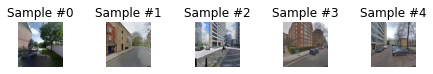

In [61]:
fig = plt.figure()

for i in range(len(train_loader)):
    image, coordinate = train_loader[i]

    print(i, image.shape, coordinate)

    ax = plt.subplot(1, SAMPLES_TO_SHOW, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    # Annoying transformation to make it easy to show the image here
    image_for_viewing = torch.transpose(torch.transpose(image, 2, 0), 1, 0)
    plt.imshow(image_for_viewing)

    if i == SAMPLES_TO_SHOW - 1:
        plt.show()
        break

## Download ResNet50

In [5]:
resnet50 = models.resnet50(True, True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)